<a href="https://colab.research.google.com/github/tomastm07/Object-Detection-OSRS-Goblin-Killer-/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rETho6j38z3DZDnzVD7K")
project = rf.workspace("tomas-marin-26qyf").project("osrs-goblins")
dataset = project.version(2).download("tensorflow")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.76
    Uninstalling opencv-python-headless-4.8.0.76:
      Successfully uninstall

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to OSRS-Goblins-2 in tensorflow:: 100%|██████████| 103/103 [00:00<00:00, 2438.63it/s]


In [3]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.8 MB/s eta 0:00:00


In [4]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import pandas as pd

Using TensorFlow backend


In [5]:
df = pd.read_csv(dataset.location  + "/train/_annotations.csv")

In [6]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,image77_png.rf.33e771629a94be8b358eed185cc8504...,1280,1024,Goblin,826,289,871,348
1,image77_png.rf.33e771629a94be8b358eed185cc8504...,1280,1024,Goblin,844,231,886,295
2,image77_png.rf.33e771629a94be8b358eed185cc8504...,1280,1024,Goblin,1049,146,1089,214
3,image77_png.rf.33e771629a94be8b358eed185cc8504...,1280,1024,Goblin,1048,91,1078,141
4,image77_png.rf.33e771629a94be8b358eed185cc8504...,1280,1024,Goblin,1254,338,1280,407


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1149 non-null   object
 1   width     1149 non-null   int64 
 2   height    1149 non-null   int64 
 3   class     1149 non-null   object
 4   xmin      1149 non-null   int64 
 5   ymin      1149 non-null   int64 
 6   xmax      1149 non-null   int64 
 7   ymax      1149 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 71.9+ KB


In [8]:
df["class"].unique()

array(['Goblin', 'goblin'], dtype=object)

In [9]:
df["class"] = df["class"].str.capitalize()

In [10]:
df["filename"] = dataset.location  + "/train/" + df["filename"]

In [11]:
df = pd.get_dummies(df, columns=['class'])

In [12]:
df.head()

,filename,width,height,xmin,ymin,xmax,ymax,class_Goblin
0,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,826,289,871,348,1
1,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,844,231,886,295,1
2,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,1049,146,1089,214,1
3,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,1048,91,1078,141,1
4,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,1254,338,1280,407,1


In [13]:
#Image data augmentation
import cv2
from albumentations import (
    HorizontalFlip, OneOf, GaussNoise, MotionBlur, MedianBlur, Blur, ShiftScaleRotate,
    OpticalDistortion, GridDistortion, PiecewiseAffine, CLAHE, Sharpen,
    Emboss, RandomBrightnessContrast, HueSaturationValue, RandomCrop,
    ElasticTransform, ImageCompression, ChannelShuffle,
    RGBShift, Normalize, ToGray, RandomSizedCrop, Compose, RandomGamma, RandomContrast, RandomScale, RandomRotate90
)
from tqdm import tqdm

aug = Compose([
    HorizontalFlip(),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        ImageCompression(quality_lower=85, quality_upper=95, p=0.5),
    ], p=0.3),
    OneOf([
        CLAHE(clip_limit=2),
        Sharpen(),
        Emboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    OneOf([
        RandomGamma(),
        RandomContrast()
    ], p=0.3),
    OneOf([
        RandomScale(),
        RandomRotate90()
    ], p=0.3),
    HueSaturationValue(p=0.3),
    ChannelShuffle(p=0.5),
    RGBShift(p=0.5),
    ToGray(p=0.3)
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def augment_and_show(aug, image, bboxes, labels=None, **kwargs):
    augmented = aug(image=image, bboxes=bboxes, labels=labels)
    return augmented['image'], augmented['bboxes']


new_rows = []
num_augmentations_per_image = 5

output_directory = dataset.location + '/augmented_images'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for filename in tqdm(df['filename'].unique(), desc="Augmenting images"):
    image_df = df[df['filename'] == filename]
    image = cv2.imread(filename)
    bboxes = image_df[['xmin', 'ymin', 'xmax', 'ymax']].values
    labels = image_df['class_Goblin'].values

    # Include the original image in the DataFrame
    for i, bbox in enumerate(bboxes):
        xmin, ymin, xmax, ymax = bbox
        new_row = {
            'filename': filename,
            'width': image.shape[1],
            'height': image.shape[0],
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
            'class_Goblin': labels[i],
            'is_augmented': False  # Indicate that this is the original image
        }
        new_rows.append(new_row)

    # Include the augmented images
    for j in range(num_augmentations_per_image):
        augmented_image, augmented_bboxes = augment_and_show(aug, image, bboxes, labels=labels)

        # Save the augmented image
        augmented_filename = f'augmented_{j}_{os.path.basename(filename)}'
        cv2.imwrite(os.path.join(output_directory, augmented_filename), augmented_image)

        for i, bbox in enumerate(augmented_bboxes):
            xmin, ymin, xmax, ymax = bbox
            new_row = {
                'filename': augmented_filename,
                'width': augmented_image.shape[1],
                'height': augmented_image.shape[0],
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'class_Goblin': labels[i],
                'is_augmented': True  # Indicate that this is an augmented image
            }
            new_rows.append(new_row)

augmented_df = pd.DataFrame(new_rows)


RandomContrast has been deprecated. Please use RandomBrightnessContrast
Augmenting images: 100%|██████████| 99/99 [02:46<00:00,  1.68s/it]


In [14]:
augmented_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,class_Goblin,is_augmented
0,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,826.0,289.0,871.0,348.0,1,False
1,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,844.0,231.0,886.0,295.0,1,False
2,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,1049.0,146.0,1089.0,214.0,1,False
3,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,1048.0,91.0,1078.0,141.0,1,False
4,/content/OSRS-Goblins-2/train/image77_png.rf.3...,1280,1024,1254.0,338.0,1280.0,407.0,1,False


In [15]:
augmented_df.loc[augmented_df['is_augmented'] == True, 'filename'] = '/content/OSRS-Goblins-2/augmented_images/' + augmented_df['filename']

In [16]:
augmented_df.shape

(6894, 9)

In [17]:
df.shape

(1149, 8)

In [18]:
# Create ragged tensors from the data and store them in a dataset

def generate_dataset(dataframe):
  grouped = dataframe.groupby('filename')
  bbox = []
  classes = []
  image_paths = []

  for name, group in grouped:
      bbox.append(group[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist())
      classes.append(group['class_Goblin'].values.tolist())
      image_paths.append(name)


  bbox = tf.ragged.constant(bbox)
  classes = tf.ragged.constant(classes)
  image_paths = tf.convert_to_tensor(image_paths)

  # Create tf dataset
  data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
  return data

val_data = generate_dataset(augmented_df[augmented_df['is_augmented'] == False])
train_data = generate_dataset(augmented_df[augmented_df['is_augmented'] == True])

In [19]:
print(train_data)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))>


In [20]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [21]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

In [22]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

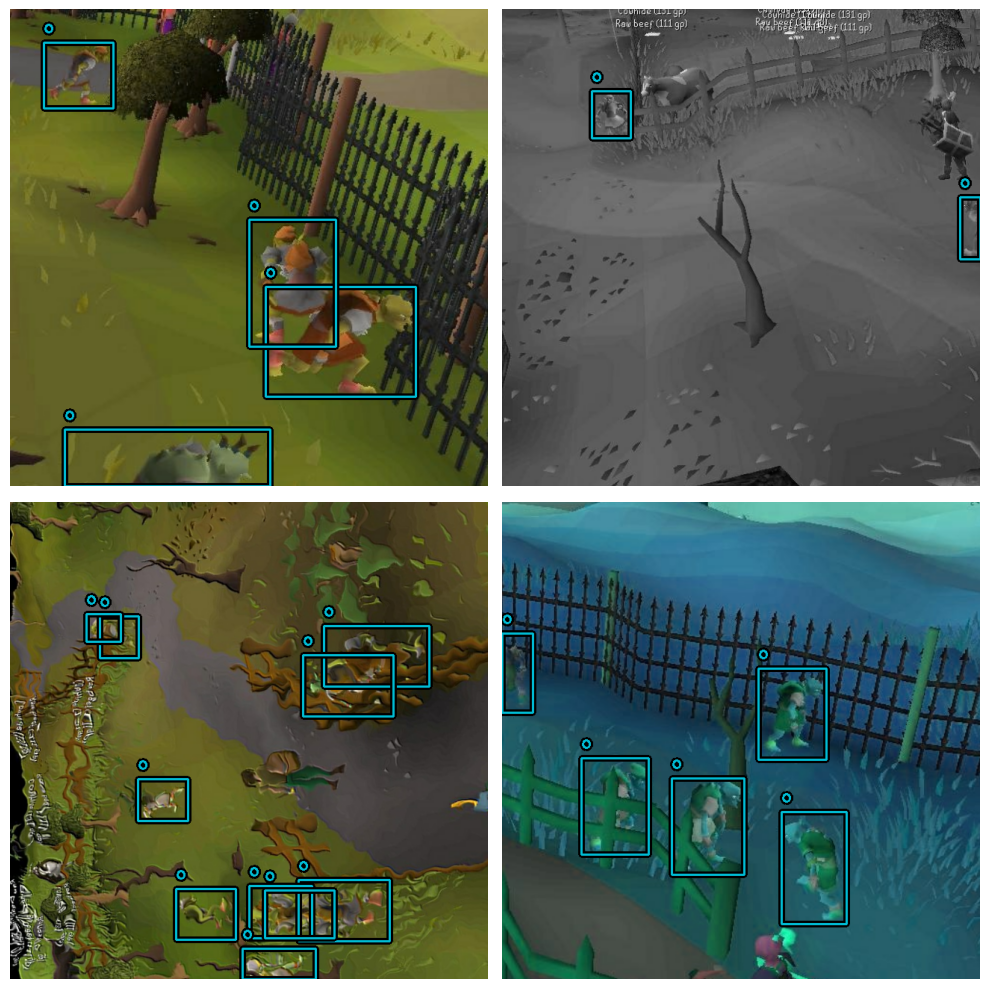

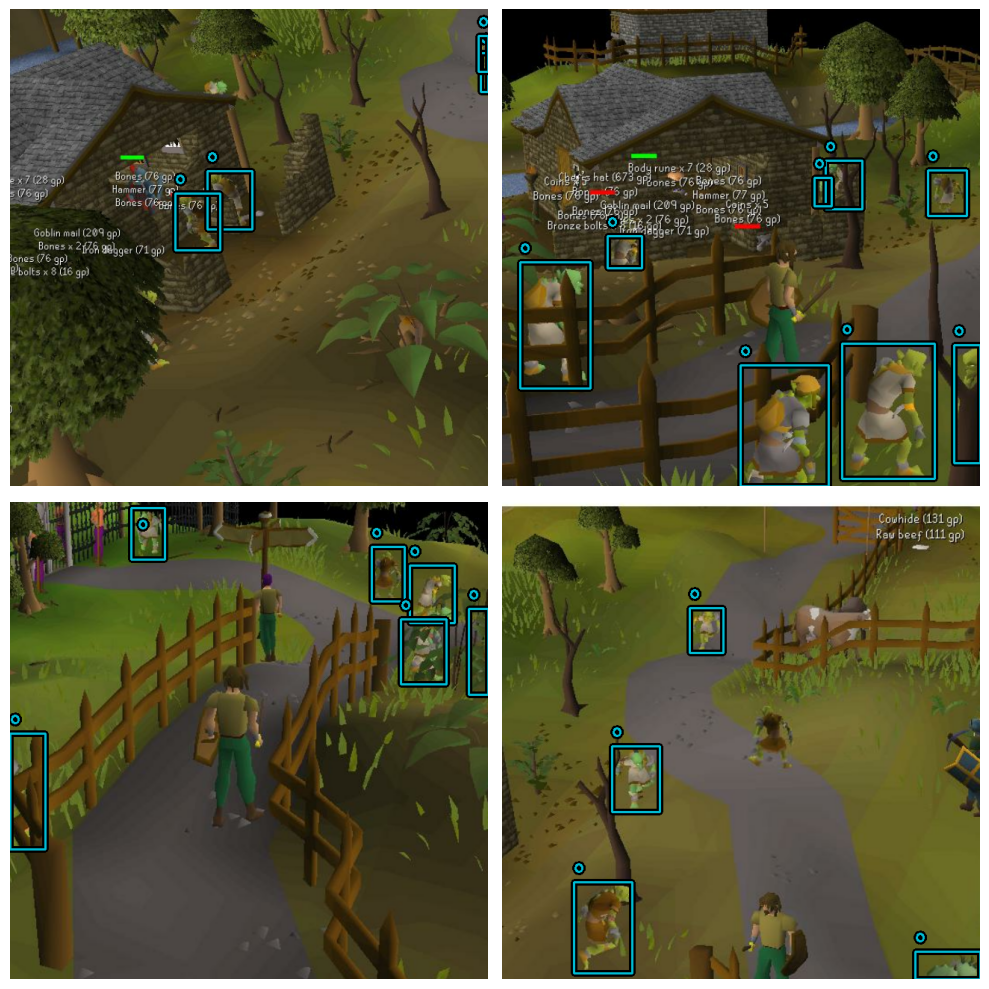

In [23]:
class_mapping = dict(zip(range(len(augmented_df["class_Goblin"])), "Goblin"))

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [24]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [25]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

20596968/20596968 [==============================] - 2s 0us/step


In [26]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [27]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
123/123 [==============================] - 63s 94ms/step - loss: 64.4834 - box_loss: 2.9459 - class_loss: 61.5374 - val_loss: 8.2005 - val_box_loss: 2.7554 - val_class_loss: 5.4450
Epoch 2/100
123/123 [==============================] - 9s 72ms/step - loss: 3.7389 - box_loss: 2.4406 - class_loss: 1.2983 - val_loss: 3.3221 - val_box_loss: 2.3893 - val_class_loss: 0.9328
Epoch 3/100
123/123 [==============================] - 9s 71ms/step - loss: 3.0226 - box_loss: 2.3566 - class_loss: 0.6659 - val_loss: 2.9138 - val_box_loss: 2.3227 - val_class_loss: 0.5912
Epoch 4/100
123/123 [==============================] - 9s 70ms/step - loss: 2.7967 - box_loss: 2.2753 - class_loss: 0.5214 - val_loss: 2.5876 - val_box_loss: 2.1410 - val_class_loss: 0.4466
Epoch 5/100
123/123 [==============================] - 9s 70ms/step - loss: 2.6232 - box_loss: 2.1946 - class_loss: 0.4287 - val_loss: 2.4533 - val_box_loss: 2.0211 - val_class_loss: 0.4321
Epoch 6/100
123/123 [==========================

1/1 [==============================] - 0s 96ms/step


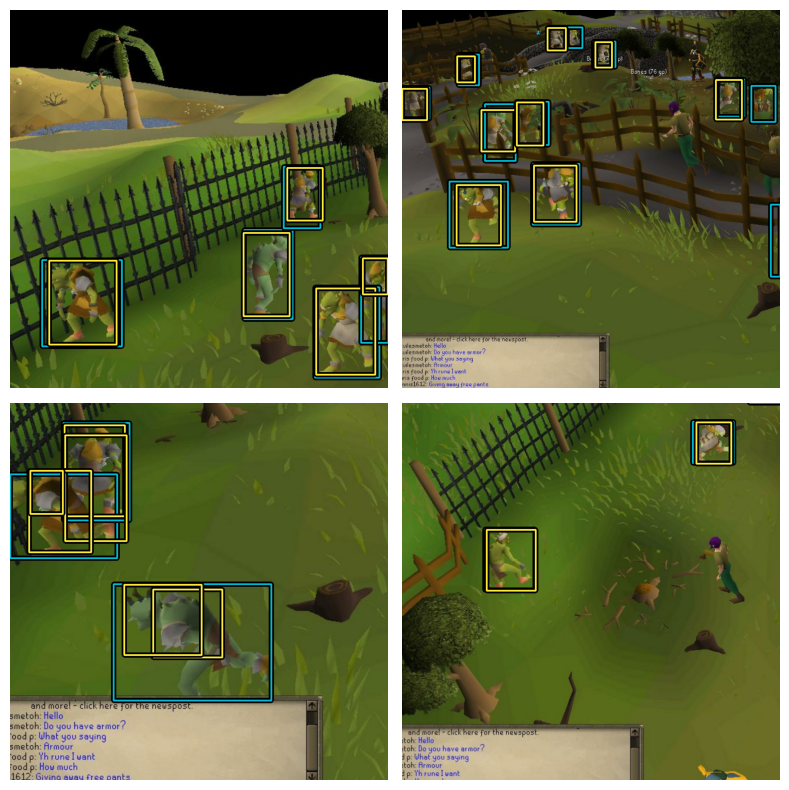

In [35]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,

    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
yolo.save("/content/drive/goblin-detectorv1")

UnimplementedError: ignored